discrimination process mining# Process Mining Module - PDEng program Data Science

This notebook is part of the Process Mining module of the JADS PDEng program on Data Science. The collection of notebooks is a *living document* and subject to change. 

# Lecture 3 - 'Conformance Checking' (Python / PM4Py)

* **Responsible Lecturer**: Dr. Felix Mannhardt, [@fmannhardt](https://twitter.com/fmannhardt)
* **Last Update**: 16th May 2021

## Setup

<img src="https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png" alt="PM4Py" style="width: 200px;"/>

In this notebook, we are using the [PM4Py library](https://pm4py.fit.fraunhofer.de/) in combination with several standard Python data science libraries:

* [pandas](https://pandas.pydata.org/)

In [ ]:
## Perform the commented out commands to install the dependencies
# %pip install pandas
# %pip install matplotlib
# %pip install pm4py

In [7]:
import pandas as pd
import pm4py
import os

## Conformance Checking

### Process Models

A common industry standard for Process Model is [BPMN](https://www.bpmn.org/), which can be created by web-based tools like [BPMN.io](https://bpmn.io/) and loaded and used by PM4Py. We load a manually drawn BPMN model that described the expected process behaviour of the `Sepsis Process`. This is a process that describes several logistical and diagnostic activities performed for patients in a hospital that are suspected to have a life-threatening sepsis condition. An event log that was extracted from the information system of a hospital is publicly available and serves as ouor running example.

In [8]:
sepsis_bpmn = pm4py.read_bpmn(os.path.join("..", "data", "sepsis.bpmn"))

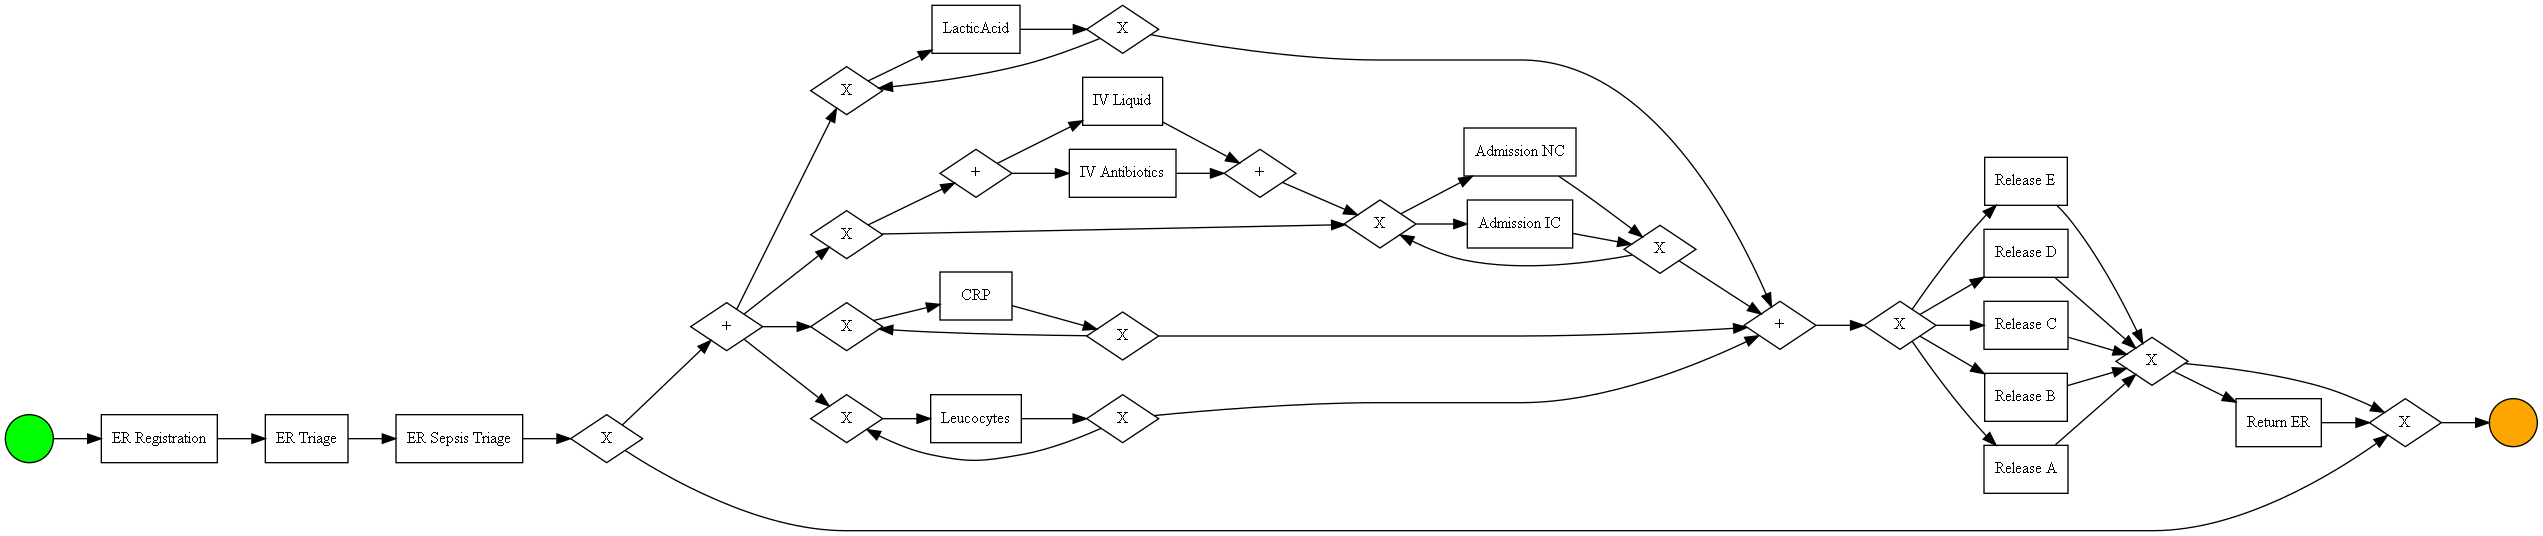

In [9]:
pm4py.vis.view_bpmn(sepsis_bpmn)

### Alignments



In [10]:
sepsis = pd.read_csv("../data/sepsis.csv", sep=';')
num_rows = len(sepsis)
print("Number of rows: {}".format(num_rows))

Number of rows: 15214


In [11]:
sepsis.head()

,case_id,activity,lifecycle,resource,timestamp,age,crp,diagnose,diagnosticartastrup,diagnosticblood,...,lacticacid,leucocytes,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,activity_instance_id,.order
0,A,ER Registration,complete,A,2014-10-22T11:15:41Z,85.0,NaN,A,True,True,...,NaN,NaN,False,True,False,True,True,True,1,1
1,A,Leucocytes,complete,B,2014-10-22T11:27:00Z,NaN,NaN,NaN,NaN,NaN,...,NaN,9.6,NaN,NaN,NaN,NaN,NaN,NaN,2,2
2,A,CRP,complete,B,2014-10-22T11:27:00Z,NaN,210.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
3,A,LacticAcid,complete,B,2014-10-22T11:27:00Z,NaN,NaN,NaN,NaN,NaN,...,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4
4,A,ER Triage,complete,C,2014-10-22T11:33:37Z,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5


In [12]:
#sepsis['timestamp'] = pd.to_datetime(sepsis['timestamp'])
sepsis_log = pm4py.format_dataframe(sepsis, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
sepsis_log = pm4py.convert_to_event_log(sepsis_log)

Now let us discover a process map as we have seen in Lecture 1:

In [ ]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

dfg = dfg_discovery.apply(sepsis_log)

dfg = dfg_discovery.apply(sepsis_log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=sepsis_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

This is clearly not usable at all. In Lecture 2, we have seen how to use Process Discovery methods to overcome this problem to a certain degree.
However, when having a normative process model such as the handmade BPMN model of the Sepsis Process there is another way to get value from the event log: by means of conformance checking with alignments.

In PM4Py, we can convert the BPMN model to a Petri net and then compute an optimal alignment between the traces contained in the event log and our model. This will give us, for each trace, a mapping from the events to the path through the model (or run) that is most similar to what has been recorded in the event log. (**Warning**: This is computationally expensive and may take a while)


In [13]:
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

sepsis_net, sepsis_im, sepsis_fm = bpmn_converter.apply(sepsis_bpmn)

sepsis_alignment = pm4py.conformance_diagnostics_alignments(sepsis_log, sepsis_net, sepsis_im, sepsis_fm) 

aligning log, completed variants ::   0%|          | 0/846 [00:00<?, ?it/s]

This is how an *alignment* of an individual trace looks like:

In [14]:
sepsis_alignment[0]

{'alignment': [('ER Registration', 'ER Registration'),
  ('Leucocytes', '>>'),
  ('CRP', '>>'),
  ('LacticAcid', '>>'),
  ('ER Triage', 'ER Triage'),
  ('ER Sepsis Triage', 'ER Sepsis Triage'),
  ('>>', None),
  ('>>', 'LacticAcid'),
  ('>>', None),
  ('IV Liquid', 'IV Liquid'),
  ('IV Antibiotics', 'IV Antibiotics'),
  ('>>', None),
  ('>>', None),
  ('Admission NC', 'Admission NC'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('>>', None),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('>>', None),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('>>', None),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('>>', None),
  ('CRP', 'CRP'),
  ('Leucocytes', 'Leucocytes'),
  ('>>', None),
  ('Release A', 'Release A'),
  ('>>', None),
  ('>>', None),
  ('>>', None)],
 'cost': 40019,
 'visited_states': 49,
 '

This can be used to project statistics on top of the Petri net representation:

aligning log, completed variants ::   0%|          | 0/846 [00:00<?, ?it/s]

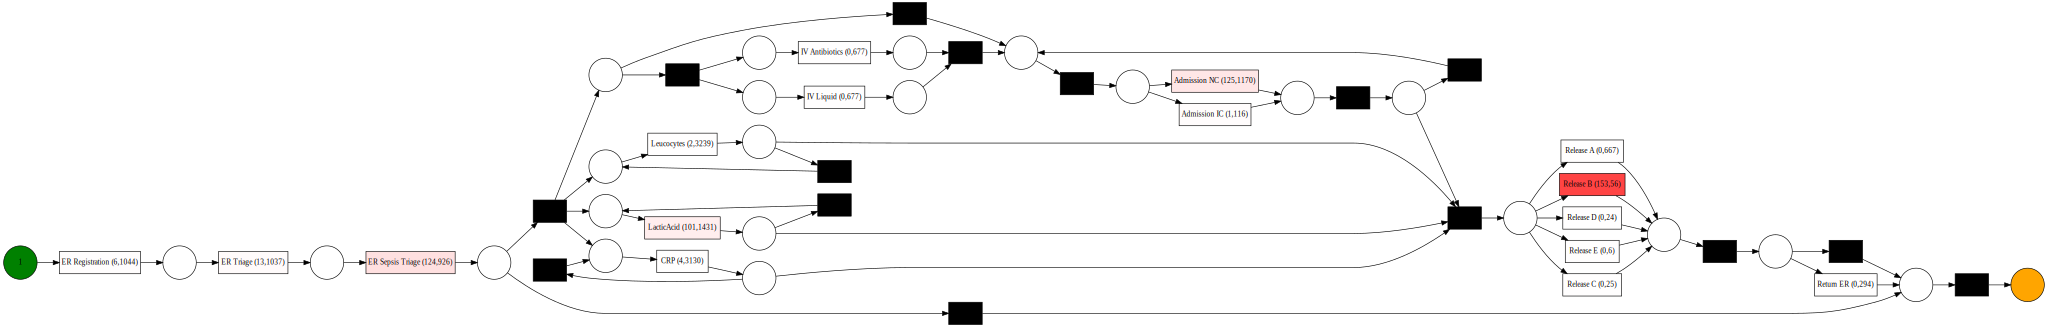

In [15]:
from pm4py.visualization.petri_net import visualizer as pn_vis

pn_vis.apply(sepsis_net, sepsis_im, sepsis_fm, sepsis_log, variant = pn_vis.Variants.ALIGNMENTS)

The statistics can be read as (number of skips or move on model, number of correct or synchronous events)